# Credit Risk Analysis

The process to balance the estimated costs of credit risks against the benefits that achieve the lender’s business objectives
redit risk analysis extends beyond credit analysis and is the process that achieves a lender’s goals by weighing the costs and benefits of taking on credit risk.

By balancing the costs and benefits of granting credit, lenders measure, analyze and manage risks their business is willing to accept.

The creditworthiness of the borrower, derived from the credit analysis process, is not the only risk lenders face. When granting credit, lenders also consider potential losses from non-performance, such as missed payments and potential bad debt. With such risks come costs, so lenders weigh them against anticipated benefits such as risk-adjusted return on capital (RAROC).
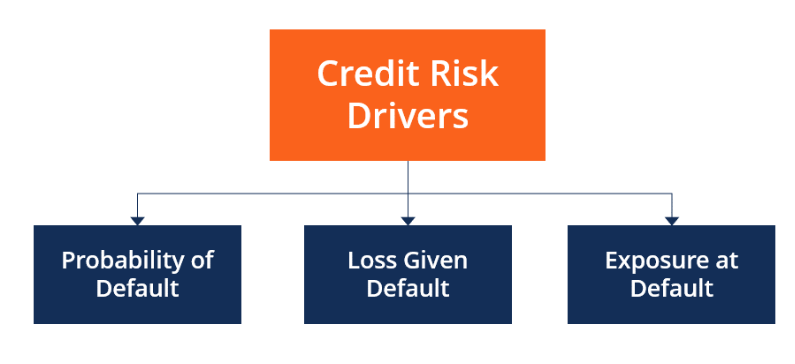

# Purpose of Credit Risk Analysis
Credit risk analysis aims to take on an acceptable level of risk to advance the lenders’ goals. Goals can include profitability, business growth, and qualitative factors. Management crafts policies that drive their business to achieve its goals.

Although credit analysis can rate risks and estimate the probability of default, default risk is only one entity-specific risk factor. Lenders consider costs and benefits holistically when determining if the anticipated outcomes are acceptable to their business and financial exposure.

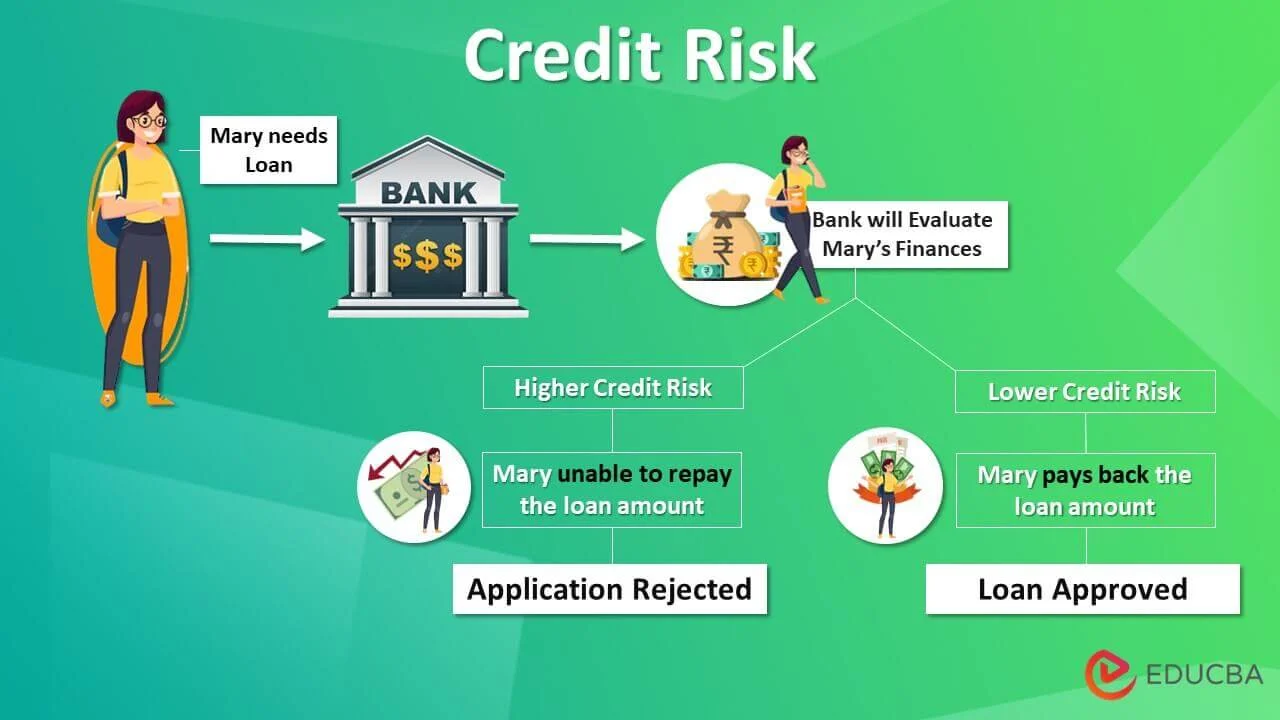

To estimate the cost of risk, lenders employ a multitude of information from the borrower, the lender, and external parties such as credit agencies. Some measures, such as credit scores and credit risk analysis models, are tools that allow lenders to estimate their expected loss (EL) via the probability of default (PD), loss-given default (LGD), and exposure at default (EAD).

# Set Kaggle Api

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API is set up successfully!")


Saving kaggle.json to kaggle.json
Kaggle API is set up successfully!


# Download the Dataset Using Kaggle API

In [ ]:
# Download the dataset
!kaggle competitions download -c GiveMeSomeCredit

# Unzip the dataset
!unzip GiveMeSomeCredit.zip

print("Dataset downloaded and extracted!")


  0% 0.00/5.16M [00:00<?, ?B/s]
100% 5.16M/5.16M [00:00<00:00, 64.6MB/s]
Archive:  GiveMeSomeCredit.zip
  inflating: Data Dictionary.xls     
  inflating: cs-test.csv             
  inflating: cs-training.csv         
  inflating: sampleEntry.csv         
Dataset downloaded and extracted!


# Load the Dataset in Pandas
Once the dataset is downloaded, we can load it using Pandas

In [ ]:
import pandas as pd

# Load the training dataset
data = pd.read_csv("cs-training.csv")

# Display dataset info
print("Dataset Loaded Successfully!")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())


Dataset Loaded Successfully!
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                       

# ata Preprocessing
We'll handle missing values, drop unnecessary columns, and balance the dataset using SMOTE.

In [ ]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Drop Unnecessary Column
data.drop(columns=["Unnamed: 0"], inplace=True)

# Handle Missing Values
imputer = SimpleImputer(strategy="median")
data["MonthlyIncome"] = imputer.fit_transform(data[["MonthlyIncome"]])
data["NumberOfDependents"] = imputer.fit_transform(data[["NumberOfDependents"]])

# Check class balance
print("Class Distribution Before SMOTE:")
print(data["SeriousDlqin2yrs"].value_counts())

# Separate features and target
X = data.drop(columns=["SeriousDlqin2yrs"])  # Features
y = data["SeriousDlqin2yrs"]  # Target variable

# Apply SMOTE to balance dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
balanced_data["SeriousDlqin2yrs"] = y_resampled

# Check new class distribution
print("\nClass Distribution After SMOTE:")
print(balanced_data["SeriousDlqin2yrs"].value_counts())

# Display dataset info after preprocessing
print("\nPreprocessed Dataset Info:")
print(balanced_data.info())


Class Distribution Before SMOTE:
SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

Class Distribution After SMOTE:
SeriousDlqin2yrs
1    139974
0    139974
Name: count, dtype: int64

Preprocessed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279948 entries, 0 to 279947
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  279948 non-null  float64
 1   age                                   279948 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  279948 non-null  int64  
 3   DebtRatio                             279948 non-null  float64
 4   MonthlyIncome                         279948 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       279948 non-null  int64  
 6   NumberOfTimes90DaysLate               279948 non-null  int64  
 7   NumberRealEstateLoansOrLines          279948

# Feature Engineering
We'll create new meaningful features that improve model performance.

In [ ]:
# Create New Features
balanced_data["DebtToIncome"] = balanced_data["DebtRatio"] * balanced_data["MonthlyIncome"]
balanced_data["TotalPastDue"] = (balanced_data["NumberOfTime30-59DaysPastDueNotWorse"] +
                                 balanced_data["NumberOfTimes90DaysLate"] +
                                 balanced_data["NumberOfTime60-89DaysPastDueNotWorse"])
balanced_data["CreditUtilization"] = balanced_data["RevolvingUtilizationOfUnsecuredLines"] / (balanced_data["NumberOfOpenCreditLinesAndLoans"] + 1)

# Replace infinite values (if any)
balanced_data.replace([np.inf, -np.inf], np.nan, inplace=True)
balanced_data.fillna(0, inplace=True)

# Drop Highly Correlated or Redundant Features (Optional)
balanced_data.drop(columns=["DebtRatio"], inplace=True)

# Display updated dataset info
print("\nUpdated Dataset Info:")
print(balanced_data.info())

# Display first few rows
balanced_data.head()



Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279948 entries, 0 to 279947
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  279948 non-null  float64
 1   age                                   279948 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  279948 non-null  int64  
 3   MonthlyIncome                         279948 non-null  float64
 4   NumberOfOpenCreditLinesAndLoans       279948 non-null  int64  
 5   NumberOfTimes90DaysLate               279948 non-null  int64  
 6   NumberRealEstateLoansOrLines          279948 non-null  int64  
 7   NumberOfTime60-89DaysPastDueNotWorse  279948 non-null  int64  
 8   NumberOfDependents                    279948 non-null  float64
 9   SeriousDlqin2yrs                      279948 non-null  int64  
 10  DebtToIncome                          279948 

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,DebtToIncome,TotalPastDue,CreditUtilization
0,0.766127,45,2,9120.0,13,0,6,0,2.0,1,7323.197016,2,0.054723
1,0.957151,40,0,2600.0,4,0,0,0,1.0,0,316.878123,0,0.191430
2,0.658180,38,1,3042.0,2,1,0,0,0.0,0,258.914887,2,0.219393
3,0.233810,30,0,3300.0,5,0,0,0,0.0,0,118.963951,0,0.038968
4,0.907239,49,1,63588.0,7,0,1,0,0.0,0,1584.975094,1,0.113405


# Train Machine Learning Models
Let's start by splitting the data into training and testing sets, then train a few models

# Next Steps After Running This Code
✅ Evaluate the model’s performance

✅ Fine-tune hyperparameters

✅ Compare with other models (Logistic Regression, XGBoost, etc.)

✅ Move to Deep Learning with PyTorch 🚀

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define features and target variable
X = balanced_data.drop(columns=["SeriousDlqin2yrs"])
y = balanced_data["SeriousDlqin2yrs"]

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
print("🔹 Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))


🔹 Accuracy Score: 0.9039649937488837

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     27925
           1       0.91      0.90      0.90     28065

    accuracy                           0.90     55990
   macro avg       0.90      0.90      0.90     55990
weighted avg       0.90      0.90      0.90     55990



# Further Optimization
**To improve performance, consider:**
✔️ Hyperparameter Tuning (GridSearchCV, RandomizedSearchCV)

✔️ Feature Selection (Identify most important features)

✔️ Trying Other Models (XGBoost, LightGBM, Neural Networks)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
df = pd.read_csv('cs-training.csv')

# Drop unnecessary column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Handling Missing Values
df = df.assign(
    MonthlyIncome=df['MonthlyIncome'].fillna(df['MonthlyIncome'].median()),
    NumberOfDependents=df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())
)

# Capping Outliers
outlier_cols = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio',
                'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
                'NumberOfTime60-89DaysPastDueNotWorse']
for col in outlier_cols:
    df[col] = df[col].clip(upper=df[col].quantile(0.99))

# Normalize Features
scaler = StandardScaler()
numerical_features = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
                      'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Splitting Data
X = df.drop(columns=['SeriousDlqin2yrs']).values
y = df['SeriousDlqin2yrs'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define Neural Network
class CreditRiskModel(nn.Module):
    def __init__(self):
        super(CreditRiskModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Model, Loss, Optimizer
model = CreditRiskModel()
criterion = nn.BCELoss()  # Binary Cross-Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

# Evaluation
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()

accuracy = (y_pred_class.eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 0.2065
Epoch 2/10, Loss: 0.1809
Epoch 3/10, Loss: 0.1801
Epoch 4/10, Loss: 0.1796
Epoch 5/10, Loss: 0.1794
Epoch 6/10, Loss: 0.1790
Epoch 7/10, Loss: 0.1790
Epoch 8/10, Loss: 0.1787
Epoch 9/10, Loss: 0.1786
Epoch 10/10, Loss: 0.1783
Accuracy: 0.9387


In [ ]:
torch.save(model.state_dict(), 'credit_risk_model.pth')


# Evaluations
**onfusion Matrix in PyTorch**
A confusion matrix helps analyze the false positives (FP) and false negatives (FN)

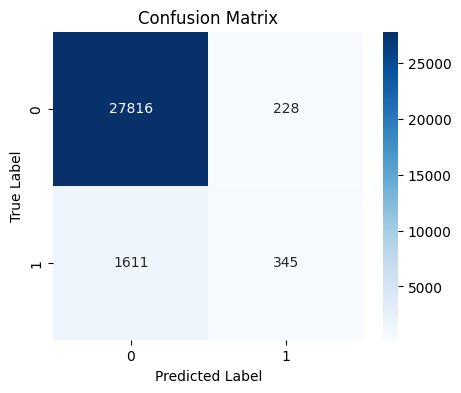

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert model outputs to binary predictions (0 or 1)
y_pred_prob = model(X_test_tensor).detach().cpu().numpy()
y_pred = (y_pred_prob > 0.5).astype(int)  # Thresholding at 0.5

y_true = y_test_tensor.cpu().numpy()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.6021
Recall: 0.1764
F1 Score: 0.2728


# ROC-AUC Score (Best for Imbalanced Data in PyTorch)
This tells how well your model separates classes

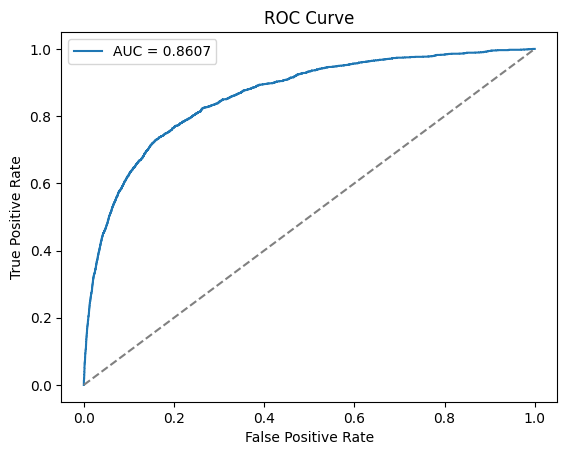

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Log Loss (Cross-Entropy Loss in PyTorch)
Log loss evaluates the confidence of probability predictions.

# K-Fold Cross-Validation in PyTorch
Instead of a single test split, use cross-validation for a better evaluation:

In [ ]:
import torch.nn.functional as F

y_pred_tensor = torch.tensor(y_pred_prob)
y_true_tensor = torch.tensor(y_true, dtype=torch.float32)

logloss = F.binary_cross_entropy(y_pred_tensor, y_true_tensor)
print(f"Log Loss: {logloss.item():.4f}")


from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_idx, val_idx in kf.split(X):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32)

    # Train your model on this fold
    model.train()
    optimizer.zero_grad()
    y_train_pred = model(X_train_tensor)
    loss = criterion(y_train_pred, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor).detach().numpy()
        accuracy = (y_val_pred.round() == y_val_fold).mean()
        accuracies.append(accuracy)

print(f"Cross-Validation Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Log Loss: 0.1763
Cross-Validation Accuracy: 0.9170 ± 0.0009


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predictions to binary (0 or 1)
y_pred_prob = model(X_test_tensor).detach().cpu().numpy()
y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold at 0.5

# Convert ground truth to numpy
y_true = y_test_tensor.cpu().numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9388
Precision: 0.6053
Recall: 0.1748
F1 Score: 0.2713
